## Resnet18

In [2]:
# slightly modified version from https://github.com/dexter2406/Monodepth2-TF2
import tensorflow as tf
from tensorflow.keras.layers import Lambda
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D, \
BatchNormalization, Layer, Add,ZeroPadding2D, Activation
from tensorflow.keras.models import Sequential, Model

from keras import backend as K
# K.get_session().graph.get_collection('variables')
# K.clear_session()

class BasicBlock_nopad(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1, block_id=-1, layer_id=-1):
        super(BasicBlock_nopad, self).__init__()
        prefix = 'conv%d_%d/' % (block_id, layer_id)
        # 1
        self.conv1 = Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride,
                            use_bias=False, padding="same", name=''.join([prefix, 'conv_1']))
        self.bn1 = BatchNormalization(name=''.join([prefix, 'BatchNorm_1']))
        self.a1 = Activation('relu')
        # 2
        self.conv2 = Conv2D(filters=filter_num, kernel_size=(3, 3),
                            use_bias=False, padding="same")
        self.bn2 = BatchNormalization(name=''.join([prefix, 'BatchNorm_2']))
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride,
                                       use_bias=False, padding="same", name=''.join([prefix, 'downsample'])))
            self.downsample.add(BatchNormalization(name='downsample/BatchNorm_3'))
        else:
            self.downsample = lambda x: x
        self.a2 = Activation('relu')

    def call(self, x, training=None, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.a1(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        identity = self.downsample(x)

        out = tf.keras.layers.add([identity, out])
        out = self.a2(out)
        return out

class BasicBlock_pad(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1, padding_mode='same', block_id=-1, layer_id=-1):
        super(BasicBlock_pad, self).__init__()
        padding = 'same'
        prefix = 'conv%d_%d/' % (block_id, layer_id)
        # 1
        self.conv1 = Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride,
                            use_bias=False, padding=padding, name=''.join([prefix, 'conv_1']))
        self.bn1 = BatchNormalization(name=''.join([prefix, 'BatchNorm_1']))
        self.a1 = Activation('relu')
        # 2
        self.conv2 = Conv2D(filters=filter_num, kernel_size=(3, 3),
                            use_bias=False, padding=padding)
        self.bn2 = BatchNormalization(name=''.join([prefix, 'BatchNorm_2']))

        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride,
                                       use_bias=False, padding='same', name=''.join([prefix, 'downsample'])))
            self.downsample.add(BatchNormalization(name='downsample/BatchNorm_3'))
        else:
            self.downsample = lambda x: x
        self.a2 = Activation('relu')

    def call(self, x, training=None, **kwargs):

        out = x
        out = self.conv1(out)
        out = self.bn1(out, training=training)
        out = self.a1(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        identity = self.downsample(x)

        out = tf.keras.layers.add([identity, out])
        out = self.a2(out)
        return out

class ResNet18_new(tf.keras.Model):
    def __init__(self, block_list=[2, 2, 2, 2], initial_filters=64, norm_inp=False):
        super(ResNet18_new, self).__init__()
        self.norm_inp = norm_inp

        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.out_filters = initial_filters

        self.conv1 = Conv2D(filters=self.out_filters, kernel_size=(7, 7), strides=2,
                            use_bias=False, padding='same', name='conv1')
        self.bn1 = BatchNormalization(name='bn1')
        self.a1 = Activation('relu', name='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same", name='maxpool')

        self.layer1 = self._make_basic_block_layer(filter_num=64, blocks=block_list[0], block_id=1)
        self.layer2 = self._make_basic_block_layer(filter_num=128, blocks=block_list[1], stride=2, block_id=2)
        self.layer3 = self._make_basic_block_layer(filter_num=256, blocks=block_list[2], stride=2, block_id=3)
        self.layer4 = self._make_basic_block_layer(filter_num=512, blocks=block_list[3], stride=2, block_id=4)

    def _make_basic_block_layer(self, filter_num, blocks, stride=1, block_id=-1):
        res_block = tf.keras.Sequential(name='seq_%d' % block_id)
        res_block.add(BasicBlock_pad(filter_num, stride=stride, block_id=block_id, layer_id=1, padding_mode='same'))

        for i in range(1, blocks):
            res_block.add(BasicBlock_nopad(filter_num, stride=1, block_id=block_id, layer_id=i + 1))

        return res_block

    def is_train(self, block_id, unfreeze_num, training):
        if unfreeze_num is None:
            return training
        num_blocks = 5
        return (num_blocks-block_id) <= unfreeze_num

    def call(self, inputs, training=None, mask=None, unfreeze_num=None):
        if self.norm_inp:
            inputs = (inputs - 0.5) * 2
        outputs = []
        x = inputs
        x = self.conv1(x)
        x = self.bn1(x, training=self.is_train(0, unfreeze_num, training))
        x = self.a1(x)
        outputs.append(x)
        x = self.pool1(x)
        x = self.layer1(x, training=self.is_train(1, unfreeze_num, training))

        outputs.append(x)
        x = self.layer2(x, training=self.is_train(2, unfreeze_num, training))
        outputs.append(x)
        x = self.layer3(x, training=self.is_train(3, unfreeze_num, training))
        outputs.append(x)
        x = self.layer4(x, training=self.is_train(4, unfreeze_num, training))
        outputs.append(x)
        return outputs
        
resnet18_model = ResNet18_new([2, 2, 2, 2],norm_inp=False)


## model

In [3]:
from collections import OrderedDict
import numpy as np
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras import backend as K
from collections import OrderedDict
from tensorflow.keras.layers import Lambda
import numpy as np

from typing import Dict, Any
import tensorflow
from tensorflow.keras import layers
from tensorflow.python.training.tracking.data_structures import NoDependency


class TF_simple_conv_block_new(tensorflow.keras.layers.Layer):
    def __init__(self,in_channels,out_channels):
        super(TF_simple_conv_block_new, self).__init__()
        self.conv = TF_conv_3x3_new(in_channels,out_channels)
        self.nonlin = tf.keras.layers.ELU(alpha=1.0)

    def build(self, input_shape):
          self.kernel = self.add_weight(name='kernel', 
                                    shape=(input_shape[1],input_shape[2]),
                                    initializer='he_uniform',
                                    trainable=True)
          super(TF_simple_conv_block_new, self).build(input_shape)  

    def call(self, inputs):
      return self.nonlin(self.conv(inputs))
    
    
class TF_conv_3x3_new(tensorflow.keras.layers.Layer):
    def __init__(self,in_channels, out_channels, use_refl=True):
        super(TF_conv_3x3_new, self).__init__()
        self.reflect_pad = Lambda(lambda x: tf.pad(x, [[0,0],[1,1],[1,1],[0,0]], 'REFLECT'))
        self.zeropad = Lambda(lambda x:tf.pad(x,[[0,0],[1,1],[1,1],[0,0]],'CONSTANT'))
        if use_refl:
          self.pad = self.reflect_pad
        else:
          self.pad = self.zeropad
        self.conv = tf.keras.layers.Conv2D(out_channels,3)
    
    def build(self, input_shape):
          self.kernel = self.add_weight(name='kernel', 
                                    shape=(input_shape[1],input_shape[2]),
                                    initializer='he_uniform',
                                    trainable=True)
          super(TF_conv_3x3_new, self).build(input_shape)  


    def call(self, inputs):
      return self.conv(self.pad(inputs))


class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super(DepthEstimationModel,self).__init__()
       
        self.tf_num_layers: int = 18 #choices=[18, 34, 50, 101, 152]
        self.tf_scales: list = range(4)  #0,1,2,3 
        self.tf_use_skips: bool = True
      
        self.tf_enc_ch = np.array([64, 64, 128, 256, 512])
        self.tf_dec_ch = np.array([16, 32, 64, 128, 256])
        if self.tf_num_layers > 34:
          self.tf_enc_ch[1:] *= 4

        # Build multiscale decoder
        self.tf_convs = NoDependency({})
        for i in range(4, -1, -1):
            self.tf_in_ch = self.tf_enc_ch[-1] if i == 4 else self.tf_dec_ch[i + 1]
            self.tf_convs[('upconv', i, 0)] = TF_simple_conv_block_new(self.tf_in_ch, self.tf_dec_ch[i])

            self.tf_in_ch = self.tf_dec_ch[i] + (self.tf_enc_ch[i - 1] if self.tf_use_skips and i > 0 else 0)
            self.tf_convs[('upconv', i, 1)] = TF_simple_conv_block_new(self.tf_in_ch, self.tf_dec_ch[i])

        # Upsample convs for each scale
        for s in self.tf_scales:
            self.tf_convs[('dispconv', s)] = TF_conv_3x3_new(self.tf_dec_ch[s], 1)
        
        self.res_model= resnet18_model

       
    def call(self, inputs):
        
        tf_features, tf_outputs = [], {}
        tfx = self.res_model.get_layer('conv1')(inputs)
        tfx = self.res_model.get_layer('bn1')(tfx)
        tf_features.append(self.res_model.get_layer('relu')(tfx))

        tf_features.append(self.res_model.get_layer('seq_1')(self.res_model.get_layer('maxpool')(tf_features[-1])))
        tf_features.append(self.res_model.get_layer('seq_2')(tf_features[-1]))
        tf_features.append(self.res_model.get_layer('seq_3')(tf_features[-1]))
        tf_features.append(self.res_model.get_layer('seq_4')(tf_features[-1]))

        # Decoder
        x = tf_features[-1]        
        for i in range(4, -1, -1):
          x = self.tf_convs[('upconv', i, 0)](x)
          x = tensorflow.keras.layers.UpSampling2D()(x)
          if self.tf_use_skips and i > 0:
              x = Concatenate(axis=3)([x, tf_features[i - 1]])
          x=self.tf_convs[('upconv', i, 1)](x)
          if i in self.tf_scales:
              out = self.tf_convs[('dispconv', i)](x)
              # tf_outputs["output_%d" % i] = tf.math.sigmoid(out)
              # out = tf.math.sigmoid(out)
        
        return out

    
model = DepthEstimationModel()
inp = tensorflow.keras.layers.Input(shape=(480,640,3))
output = model(inp)
model = tf.keras.Model(inputs=inp, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
depth_estimation_model (Dept (None, 480, 640, 1)       11186112  
Total params: 11,186,112
Trainable params: 11,176,512
Non-trainable params: 9,600
_________________________________________________________________


## Data - root

In [4]:
!git clone https://github.com/jideilori/DenseDepth

Cloning into 'DenseDepth'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 298 (delta 23), reused 25 (delta 7), pack-reused 242
Receiving objects: 100% (298/298), 12.14 MiB | 35.42 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [5]:
%cd ./DenseDepth/Tensorflow/

/kaggle/working/DenseDepth/Tensorflow


In [6]:
!curl -L -o 'nyu_data.zip' 'https://drive.google.com/u/0/uc?id=1fdFu5NGXe4rTLYKD5wOqk9dl-eJOefXo&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4195M  100 4195M    0     0   116M      0  0:00:36  0:00:36 --:--:--  126M5M


In [9]:
!ls 

DenseDepth.ipynb  data.py      loss.py	 nyu_data.zip
Evaluate.ipynb	  evaluate.py  model.py


In [11]:
!unzip -q nyu_data.zip

In [12]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip

--2022-04-12 10:22:52--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.56.27
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.56.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406362472 (1.3G) [application/zip]
Saving to: ‘nyu_test.zip’

nyu_test.zip        100%[===================>]   1.31G  30.1MB/s    in 45s     

2022-04-12 10:23:38 (29.6 MB/s) - ‘nyu_test.zip’ saved [1406362472/1406362472]



In [13]:
import tensorflow as tf

from io import BytesIO
from zipfile import ZipFile
from sklearn.utils import shuffle

class DataLoader():
    def __init__(self, csv_file='data/nyu2_train.csv', DEBUG=False):
        self.shape_rgb = (480, 640, 3)
        self.shape_depth = (480, 640, 1)
        self.read_nyu_data(csv_file, DEBUG=DEBUG)

    def nyu_resize(self, img, resolution=480, padding=6):
        from skimage.transform import resize
        return resize(img, (resolution, int(resolution*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True )

    def read_nyu_data(self, csv_file, DEBUG=False):
        csv = open(csv_file, 'r').read()
        nyu2_train = list((row.split(',') for row in (csv).split('\n') if len(row) > 0))

        # Dataset shuffling happens here
        nyu2_train = shuffle(nyu2_train, random_state=0)

        # Test on a smaller dataset
        if DEBUG: nyu2_train = nyu2_train[:10]
        
        # A vector of RGB filenames.
        self.filenames = [i[0] for i in nyu2_train]

        # A vector of depth filenames.
        self.labels = [i[1] for i in nyu2_train]

        # Length of dataset
        self.length = len(self.filenames)

    def _parse_function(self, filename, label): 
        # Read images from disk
        image_decoded = tf.image.decode_jpeg(tf.io.read_file(filename))
        depth_resized = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(label)), [self.shape_depth[0], self.shape_depth[1]])

        # Format
        rgb = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
        depth = tf.image.convert_image_dtype(depth_resized / 255.0, dtype=tf.float32)
        
        # Normalize the depth values (in cm)
        depth = 1000 / tf.clip_by_value(depth * 1000, 10, 1000)

        return rgb, depth

    def get_batched_dataset(self, batch_size):
        self.dataset = tf.data.Dataset.from_tensor_slices((self.filenames, self.labels))
        self.dataset = self.dataset.shuffle(buffer_size=len(self.filenames), reshuffle_each_iteration=True)
        self.dataset = self.dataset.repeat()
        self.dataset = self.dataset.map(map_func=self._parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        self.dataset = self.dataset.batch(batch_size=batch_size)

        return self.dataset



## train

In [14]:
# Parameters
batch_size     = 8
learning_rate  = 0.0001
epochs         = 10


dl = DataLoader()
train_generator = dl.get_batched_dataset(batch_size)

print('Data loader ready.')


# Compile & Train
import tensorflow
from loss import depth_loss_function

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(loss=depth_loss_function, optimizer=optimizer)

# Create checkpoint callback
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

Data loader ready.


In [15]:
# Start training
model.fit(train_generator, epochs=5, steps_per_epoch=dl.length//batch_size, callbacks=[cp_callback])

2022-04-12 10:24:12.578552: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-12 10:24:16.646094: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6336/6336 [==============================] - 1375s 215ms/step - loss: 0.2185

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/5
6336/6336 [==============================] - 1366s 216ms/step - loss: 0.1730

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/5
6336/6336 [==============================] - 1367s 216ms/step - loss: 0.1491

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/5
6336/6336 [==============================] - 1367s 216ms/step - loss: 0.1332

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/5
6336/6336 [==============================] - 1366s 216ms/step - loss: 0.1221

Epoch 00005: saving model to training_1/cp.ckpt


In [18]:
model.save_weights('/kaggle/working/est_model_1')

## Evaluate

In [19]:
# Load model

import tensorflow as tf
checkpoint_path = "training_1/cp.ckpt"
model.load_weights(checkpoint_path)

print('Model weights loaded.')

# Load and evalute on Eigen's test data

from evaluate import load_test_data, evaluate

rgb, depth, crop = load_test_data()
evaluate(model, rgb, depth, crop)

# 0.895 0.980 0.966 0.103 0.390 0.043

Model weights loaded.
Loading test data...Test data loaded.

        a1,         a2,         a3,        rel,        rms,     log_10
    0.4129,     0.7027,     0.8580,     0.4662,     1.1710,     0.1546


Loading model...

Loaded (12) images of size (480, 640, 3).
(12, 480, 640, 1)


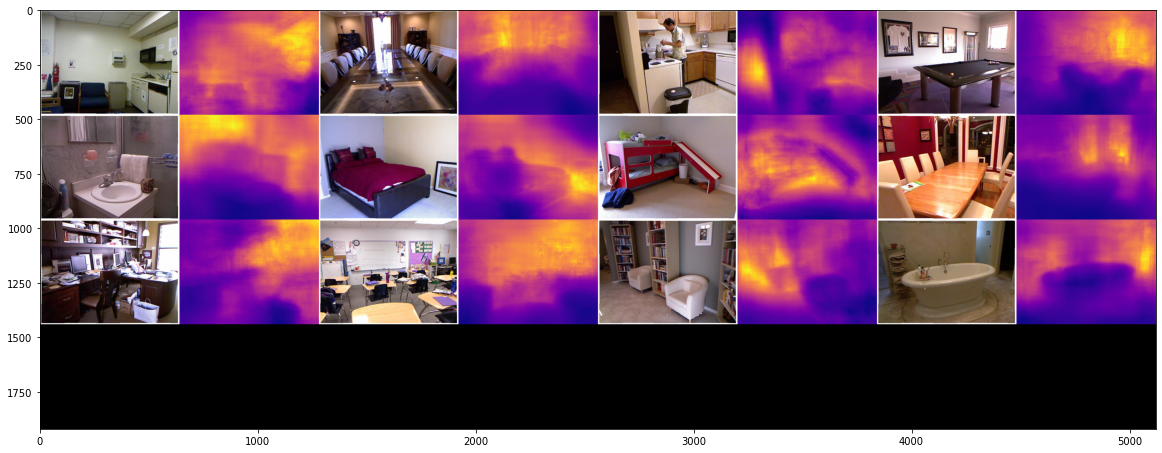

In [22]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from tensorflow.keras.layers import Layer, InputSpec
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt


print('Loading model...')

inputs = load_images( glob.glob('/kaggle/working/DenseDepth/examples/*.png') )
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)
print(outputs.shape)
#matplotlib problem on ubuntu terminal fix
#matplotlib.use('TkAgg')   

# Display results
viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(20,20))
plt.imshow(viz,cmap='magma')
plt.savefig('test.png')
# plt.show()


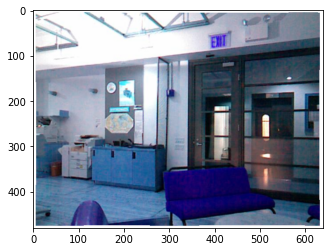

In [32]:
import cv2
test_depth = cv2.imread('/kaggle/working/DenseDepth/Tensorflow/data/nyu2_test/00035_colors.png')
plt.imshow(test_depth)

(480, 640, 3)
(1, 480, 640, 3)
(480, 640, 1)


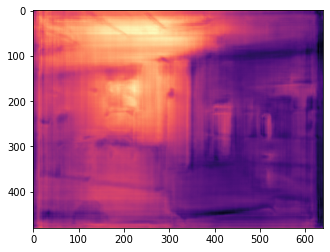

In [29]:
test_depth = cv2.imread('/kaggle/working/DenseDepth/Tensorflow/data/nyu2_test/00035_colors.png')
print(test_depth.shape)
test_depth = np.expand_dims(test_depth,0)
print(test_depth.shape)

pred = model.predict(test_depth).squeeze(0)
print(pred.shape)
plt.imshow(pred.squeeze(2),cmap='magma')